CRS match confirmed.
Intersection check: Yes


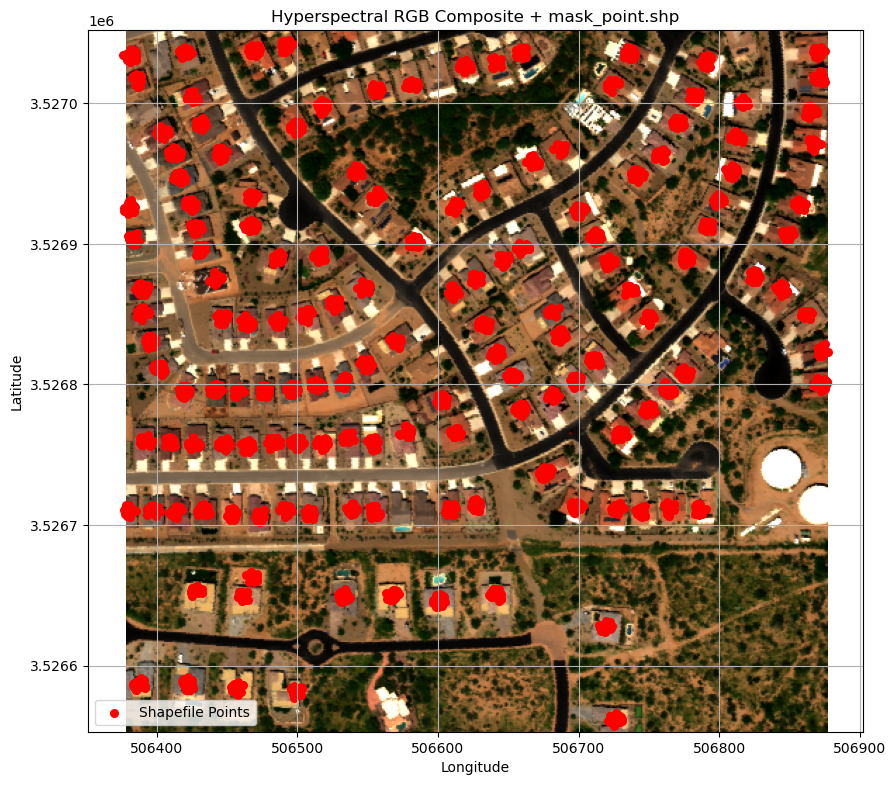

In [32]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np

raster_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_2021.tif"  
shapefile_path = r"E:\Hyperspectral\DataOutput\Mask1.shp"            

RED_BAND = 53
GREEN_BAND = 35
BLUE_BAND = 19

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    raster_extent = box(*raster_bounds)
    
    # Read RGB bands
    red = src.read(RED_BAND)
    green = src.read(GREEN_BAND)
    blue = src.read(BLUE_BAND)
    transform = src.transform

rgb = np.stack([red, green, blue], axis=-1).astype(np.float32)
rgb_min, rgb_max = np.percentile(rgb, (2, 98))
rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min + 1e-6), 0, 1)

gdf = gpd.read_file(shapefile_path)
shapefile_crs = gdf.crs

if shapefile_crs != raster_crs:
    print("CRS mismatch. Reprojecting shapefile...")
    gdf = gdf.to_crs(raster_crs)
else:
    print("CRS match confirmed.")

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    raster_extent = box(*raster_bounds)
    transform = src.transform

    #  print("Band Data Types:")
    # for i in range(1, src.count + 1):
    #     print(f"  Band {i}: {src.dtypes[i - 1]}")


raster_geom = gpd.GeoDataFrame(geometry=[raster_extent], crs=raster_crs)
intersects = gdf.intersects(raster_extent).any()
print("Intersection check:", "Yes" if intersects else "No")

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb, extent=[raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top])
gdf.plot(ax=ax, color='red', markersize=30, label='Shapefile Points')

plt.legend()
plt.title("Hyperspectral RGB Composite + mask_point.shp")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [ ]:
import rasterio
import numpy as np

input_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_2021.tif"
output_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_2021_Scaled.tif"

with rasterio.open(input_path) as src:
    profile = src.profile
    height, width = src.height, src.width

    valid_bands = []
    scaled_bands = []

   
    for i in range(1, src.count + 1):
        band = src.read(i).astype('float32')
        band_min = band.min()
        band_max = band.max()

        if band_max - band_min < 1e-6:
            print(f"Band {i}: Skipped (flat or invalid)")
            continue

        scaled_band = (band - band_min) / (band_max - band_min)
        scaled_bands.append(scaled_band)
        valid_bands.append(i)

    scaled_data = np.stack(scaled_bands).astype('float32')

    profile.update(dtype='float32', count=len(valid_bands))

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(scaled_data)

print(f"Saved {len(valid_bands)} valid normalized bands to:\n{output_path}")
print(f"{src.count - len(valid_bands)} flat/invalid bands.")


Band 192: Skipped (flat or invalid)
Band 193: Skipped (flat or invalid)
Band 194: Skipped (flat or invalid)
Band 195: Skipped (flat or invalid)
Band 196: Skipped (flat or invalid)
Band 197: Skipped (flat or invalid)
Band 198: Skipped (flat or invalid)
Band 199: Skipped (flat or invalid)
Band 200: Skipped (flat or invalid)
Band 201: Skipped (flat or invalid)
Band 202: Skipped (flat or invalid)
Band 203: Skipped (flat or invalid)
Band 204: Skipped (flat or invalid)
Band 205: Skipped (flat or invalid)
Band 206: Skipped (flat or invalid)
Band 207: Skipped (flat or invalid)
Band 208: Skipped (flat or invalid)
Band 209: Skipped (flat or invalid)
Band 210: Skipped (flat or invalid)
Band 211: Skipped (flat or invalid)
Band 212: Skipped (flat or invalid)
Band 282: Skipped (flat or invalid)
Band 283: Skipped (flat or invalid)
Band 284: Skipped (flat or invalid)
Band 285: Skipped (flat or invalid)
Band 286: Skipped (flat or invalid)
Band 287: Skipped (flat or invalid)
Band 288: Skipped (flat or i

Reading 372 bands...


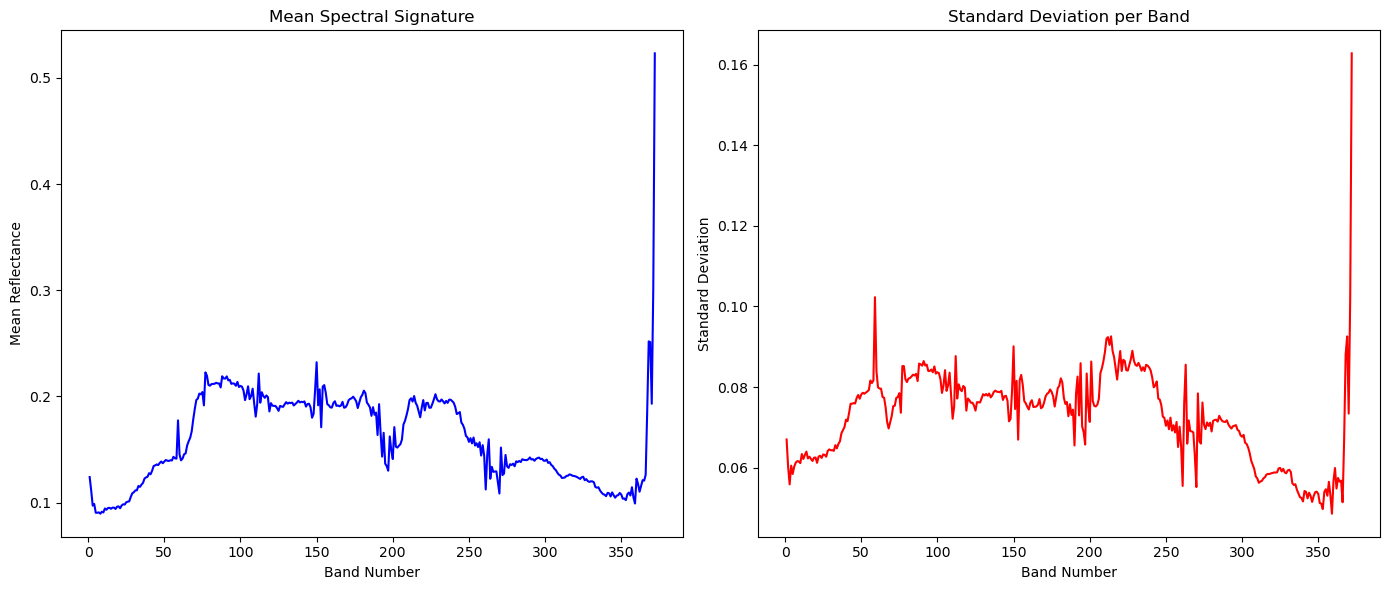

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

input_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_2021_Scaled.tif"

with rasterio.open(input_path) as src:
    num_bands = src.count
    height, width = src.height, src.width
    
    mean_spectrum = []
    std_spectrum = []
    
    print(f"Reading {num_bands} bands...")
    for i in range(1, num_bands + 1):
        band = src.read(i).astype('float32')
        mean_val = np.mean(band)
        std_val = np.std(band)
        
        mean_spectrum.append(mean_val)
        std_spectrum.append(std_val)

mean_spectrum = np.array(mean_spectrum)
std_spectrum = np.array(std_spectrum)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_bands + 1), mean_spectrum, color='blue')
plt.title("Mean Spectral Signature")
plt.xlabel("Band Number")
plt.ylabel("Mean Reflectance")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_bands + 1), std_spectrum, color='red')
plt.title("Standard Deviation per Band")
plt.xlabel("Band Number")
plt.ylabel("Standard Deviation")

plt.tight_layout()
plt.show()


Top 10 bands (1-based indices): [59, 150, 211, 212, 213, 214, 228, 369, 371, 372]


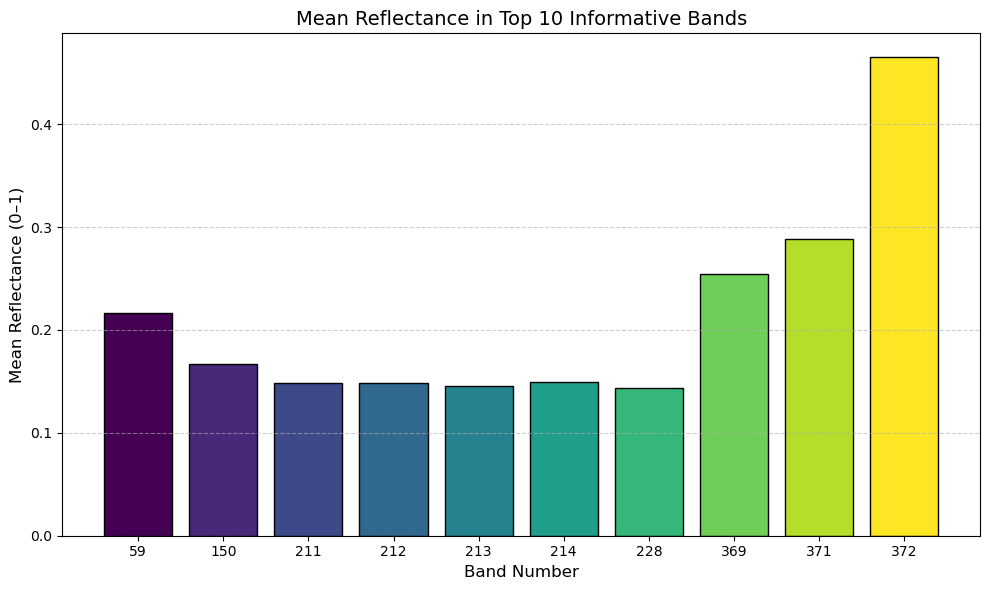

In [4]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

image_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_2021_Scaled.tif"
mask_path = r"E:\Hyperspectral\DataOutput\Mask.shp"

Top_Band = 10  

with rasterio.open(image_path) as src:
    image_data = src.read()  
    transform = src.transform
    crs = src.crs
    num_bands = src.count

band_std = np.std(image_data.reshape(num_bands, -1), axis=1)
top_band_indices = np.argsort(band_std)[-Top_Band:]
top_band_indices = np.sort(top_band_indices)  
band_labels = [i + 1 for i in top_band_indices]  

print(f"Top {Top_Band} bands (1-based indices): {band_labels}")

gdf = gpd.read_file(mask_path).to_crs(crs)

def get_pixel_coordinates(point, transform):
    col, row = ~transform * (point.x, point.y)
    return int(row), int(col)

point_spectra = []
for idx, row in gdf.iterrows():
    geom = row.geometry
    if isinstance(geom, Point):
        r, c = get_pixel_coordinates(geom, transform)
        if 0 <= r < image_data.shape[1] and 0 <= c < image_data.shape[2]:
            spectrum = image_data[:, r, c]
            top_spectrum = spectrum[top_band_indices]
            point_spectra.append(top_spectrum)
        else:
            print(f"Point {idx} is out of bounds.")
    else:
        print(f"Non-point geometry at index {idx} — skipped.")

point_spectra = np.array(point_spectra)
mean_point_spectrum = np.mean(point_spectra, axis=0)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, Top_Band))  # Color map

plt.bar([str(b) for b in band_labels], mean_point_spectrum, color=colors, edgecolor='k')
plt.title(f"Mean Reflectance in Top {Top_Band} Informative Bands", fontsize=14)
plt.xlabel("Band Number", fontsize=12)
plt.ylabel("Mean Reflectance (0–1)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Image shape: (372, 499, 499)

🎯 Top 10 bands (1-based indices):
['Band 59', 'Band 150', 'Band 211', 'Band 212', 'Band 213', 'Band 214', 'Band 228', 'Band 369', 'Band 371', 'Band 372']

✅ Extracted 144 spectra points.

💾 Saved Top 10 Bands Image to:
E:\Hyperspectral\DataOutput\NEON_HSI_Top10Bands.tif


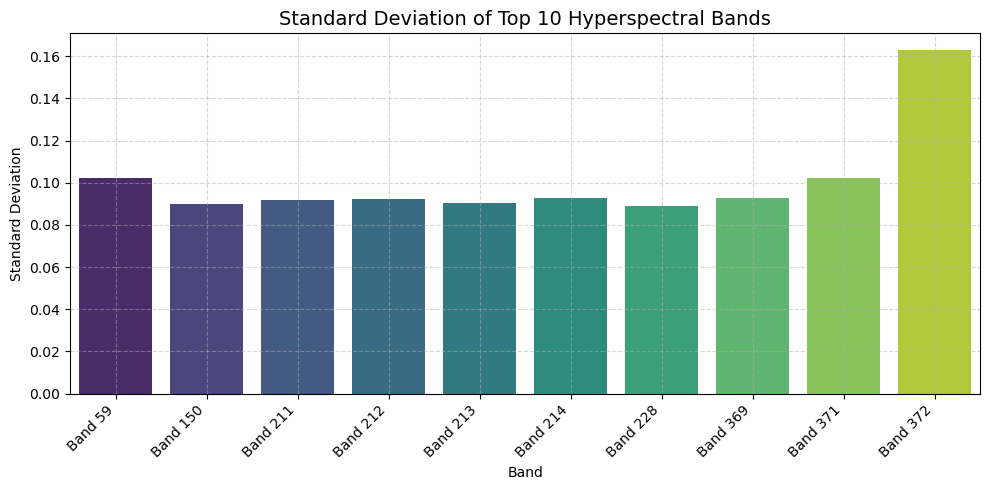

In [8]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely.geometry import Point
import os

image_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_2021_Scaled.tif"
mask_path = r"E:\Hyperspectral\DataOutput\Mask.shp"
output_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_Top10Bands.tif"

Top_Band = 10 

with rasterio.open(image_path) as src:
    image_data = src.read() 
    transform = src.transform
    crs = src.crs
    profile = src.profile
    num_bands = src.count

    if src.descriptions and all(src.descriptions):
        band_names = list(src.descriptions)
    else:
        band_names = [f"Band {i+1}" for i in range(num_bands)]

print(f"Image shape: {image_data.shape}")

band_std = np.std(image_data.reshape(num_bands, -1), axis=1)
top_band_indices = np.argsort(band_std)[-Top_Band:]  
top_band_indices = np.sort(top_band_indices) 

band_labels = [i + 1 for i in top_band_indices]
band_labels_str = [band_names[i] for i in top_band_indices]

print(f"Top {Top_Band} bands (1-based indices):")
print(band_labels_str)

gdf = gpd.read_file(mask_path).to_crs(crs)

def get_pixel_coordinates(point, transform):
    col, row = ~transform * (point.x, point.y)
    return int(row), int(col)

point_spectra = []
for idx, row in gdf.iterrows():
    geom = row.geometry
    if isinstance(geom, Point):
        r, c = get_pixel_coordinates(geom, transform)
        if 0 <= r < image_data.shape[1] and 0 <= c < image_data.shape[2]:
            spectrum = image_data[:, r, c]
            top_spectrum = spectrum[top_band_indices]
            point_spectra.append(top_spectrum)
        else:
            print(f"Point {idx} is out of bounds.")
    else:
        print(f"Non-point geometry at index {idx} — skipped.")

print(f"Extracted {len(point_spectra)} spectra points.")

top_image_data = image_data[top_band_indices, :, :]
profile.update(count=Top_Band, dtype='float32')

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(top_image_data)
    dst.descriptions = [band_names[i] for i in top_band_indices]

print(f"Saved Top {Top_Band} Bands Image to:\n{output_path}")

bar_labels = [band_names[i] for i in top_band_indices]
top_band_stds = band_std[top_band_indices]

df = pd.DataFrame({
    "Band": bar_labels,
    "StdDev": top_band_stds
})

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Band", y="StdDev", hue="Band", palette="viridis", legend=False)
plt.title(f"Standard Deviation of Top {Top_Band} Hyperspectral Bands", fontsize=14)
plt.xlabel("Band")
plt.ylabel("Standard Deviation")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [24]:
import rasterio
import geopandas as gpd
import pandas as pd

image_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_Top10Bands.tif"
training_sample_path = r"E:\Hyperspectral\DataOutput\Non_Mask1.shp"
output_csv =r"E:\Hyperspectral\DataOutput\Traning_Sample_NonBuitup.csv"

training_samples = gpd.read_file(training_sample_path)

with rasterio.open(image_path) as src:
    coords = [(x, y) for x, y in zip(training_samples.geometry.x, training_samples.geometry.y)]
    reflectance_values = list(src.sample(coords))
    
df = pd.DataFrame(reflectance_values, columns=[f"Band_{i+1}" for i in range(src.count)])

df["Class"] = "NonBuiltup"
df["Class_Value"] = 2

df["Longitude"] = training_samples.geometry.x
df["Latitude"] = training_samples.geometry.y

df.to_csv(output_csv, index=False)

print(f"Extracted reflectance data saved to {output_csv}")

Extracted reflectance data saved to E:\Hyperspectral\DataOutput\Traning_Sample_NonBuitup.csv


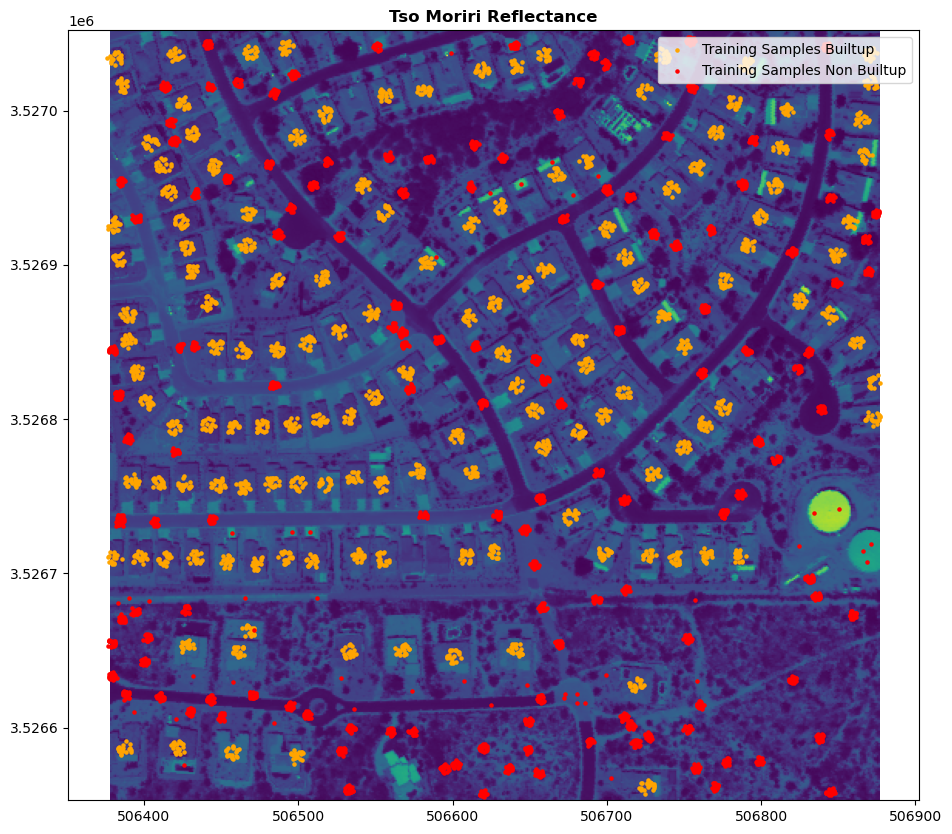

In [25]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show

image_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_Top10Bands.tif"
training_sample_path = r"E:\Hyperspectral\DataOutput\Mask1.shp"
training_sample_path1 = r"E:\Hyperspectral\DataOutput\Non_Mask1.shp"

with rasterio.open(image_path) as src:
    fig, ax = plt.subplots(figsize=(12, 10))
    show(src, ax=ax, title="Tso Moriri Reflectance")

training_samples = gpd.read_file(training_sample_path)
training_samples.plot(ax=ax, marker='o', color='orange', markersize=5, label="Training Samples Builtup")

training_samples1 = gpd.read_file(training_sample_path1)
training_samples1.plot(ax=ax, marker='o', color='red', markersize=5, label="Training Samples Non Builtup")

plt.legend(loc='upper right')
plt.show()


In [28]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os
import matplotlib.pyplot as plt
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
from sklearn.metrics import r2_score, mean_squared_error

image_path = r"E:\Hyperspectral\DataOutput\NEON_HSI_Top10Bands.tif"
csv_paths = [
    r"E:\Hyperspectral\DataOutput\Traning_Sample_Buitup.csv",
    r"E:\Hyperspectral\DataOutput\Traning_Sample_NonBuitup.csv"
]
model_path = r"E:\Hyperspectral\DataOutput\rf_model.pkl"
output_path = r"E:\Hyperspectral\DataOutput\RF_Prediction.tif"

df_list = [pd.read_csv(p) for p in csv_paths]
df = pd.concat(df_list, ignore_index=True)

df = df.dropna()

# Features and Labels
feature_cols = [f"Band_{i}" for i in range(1, 11)]
X_train = df[feature_cols].values
y_train = df["Class_Value"].values

print("Class distribution in training data:")
print(pd.Series(y_train).value_counts())

rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

joblib.dump(rf, model_path)
print("Random Forest model trained and saved.")

with rasterio.open(image_path) as src:
    img = src.read()
    meta = src.meta.copy()
    height, width = src.height, src.width

n_bands, n_rows, n_cols = img.shape
flat_pixels = img.reshape(n_bands, -1).T

nodata_mask = np.all(flat_pixels == 0, axis=1)

print(f"Total pixels: {flat_pixels.shape[0]}")
print(f"Valid pixels: {np.sum(~nodata_mask)}")
print(f"NoData pixels: {np.sum(nodata_mask)}")

valid_pixels = flat_pixels[~nodata_mask]
predicted = rf.predict(valid_pixels)

classified = np.full(flat_pixels.shape[0], -1, dtype=np.int16)
classified[~nodata_mask] = predicted
classified = classified.reshape(n_rows, n_cols)

meta.update({
    'count': 1,
    'dtype': 'int16'
})

with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(classified, 1)

print(f"Classification saved: {output_path}")

y_pred_train = rf.predict(X_train)
print("\n✅ Training Data Evaluation:")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

r2 = r2_score(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"✅ R² Score (Training): {r2:.4f}")
print(f"✅ RMSE (Training): {rmse:.4f}")

builtup_class_value = 1 
builtup_pixel_count = np.sum(predicted == builtup_class_value)
print(f"Valid Built-up pixels predicted: {builtup_pixel_count}")

builtup_percentage = (builtup_pixel_count / predicted.size) * 100
print(f"Built-up coverage: {builtup_percentage:.2f}% of valid area")

proba = rf.predict_proba(valid_pixels) 

class_labels = rf.classes_
builtup_index = np.where(class_labels == builtup_class_value)[0][0]

builtup_proba = proba[:, builtup_index]

threshold_mask = builtup_proba > 0.5

thresholded_builtup = np.zeros(flat_pixels.shape[0], dtype=np.uint8)
thresholded_builtup[~nodata_mask] = threshold_mask.astype(np.uint8)
thresholded_builtup = thresholded_builtup.reshape(n_rows, n_cols)

results = (
    {'properties': {'class': 1}, 'geometry': shape(geom)}
    for geom, val in shapes(thresholded_builtup.astype(np.uint8), mask=(thresholded_builtup == 1), transform=src.transform)
)
gdf = gpd.GeoDataFrame.from_features(list(results), crs=src.crs)

gdf["area"] = gdf.geometry.area
min_area = 50
gdf = gdf[gdf["area"] > min_area]

shapefile_path = r"E:\Hyperspectral\DataOutput\Builtup.shp"
gdf.to_file(shapefile_path)
print(f"✅ Shapefile saved: {shapefile_path}")


✅ Class distribution in training data:
2    2903
1    2880
Name: count, dtype: int64
✅ Random Forest model trained and saved.
Total pixels: 249001
Valid pixels: 249001
NoData pixels: 0
✅ Classification saved: E:\Hyperspectral\DataOutput\RF_Prediction.tif

✅ Training Data Evaluation:
[[2872    8]
 [   1 2902]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2880
           2       1.00      1.00      1.00      2903

    accuracy                           1.00      5783
   macro avg       1.00      1.00      1.00      5783
weighted avg       1.00      1.00      1.00      5783

✅ R² Score (Training): 0.9938
✅ RMSE (Training): 0.0394
✅ Valid Built-up pixels predicted: 62877
✅ Built-up coverage: 25.25% of valid area
✅ Shapefile saved: E:\Hyperspectral\DataOutput\Builtup.shp
